## [1] Import & Data Check

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/house price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/house price/test.csv')

In [ ]:
print(data.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [6]:
num_feats = data.dtypes[data.dtypes != 'object'].index
cat_feats = data.dtypes[data.dtypes == 'object'].index

print('수치형 변수: ', len(num_feats))
print('명목형 변수: ', len(cat_feats))

수치형 변수:  38
명목형 변수:  43


### 이상치 탐색 및 제거

In [7]:
out = []

for i in num_feats.drop(['SalePrice']):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    outlier = data[(data[i] < (Q1 - 1.5 * IQR)) | (data[i] > (Q3 + 1.5 * IQR))].index
    out.extend(outlier)

* 중복이 3번 이상인 것만 제거

In [8]:
multi_out = list(k for k, v in Counter(out).items() if v > 2)
data = data.drop(multi_out, axis = 0).reset_index(drop = True)
data.shape

(1305, 81)

## [2] EDA

### 수치형 변수 탐색

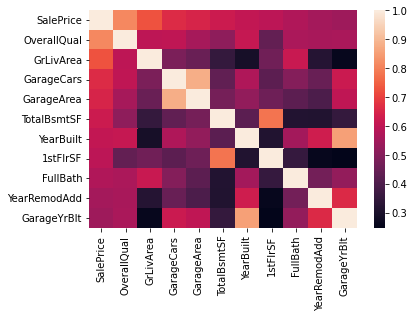

In [ ]:
cols = data[num_feats].corr().abs().nlargest(11, 'SalePrice')['SalePrice'].index

sns.heatmap(data[cols].corr())

### 명목형 변수 탐색

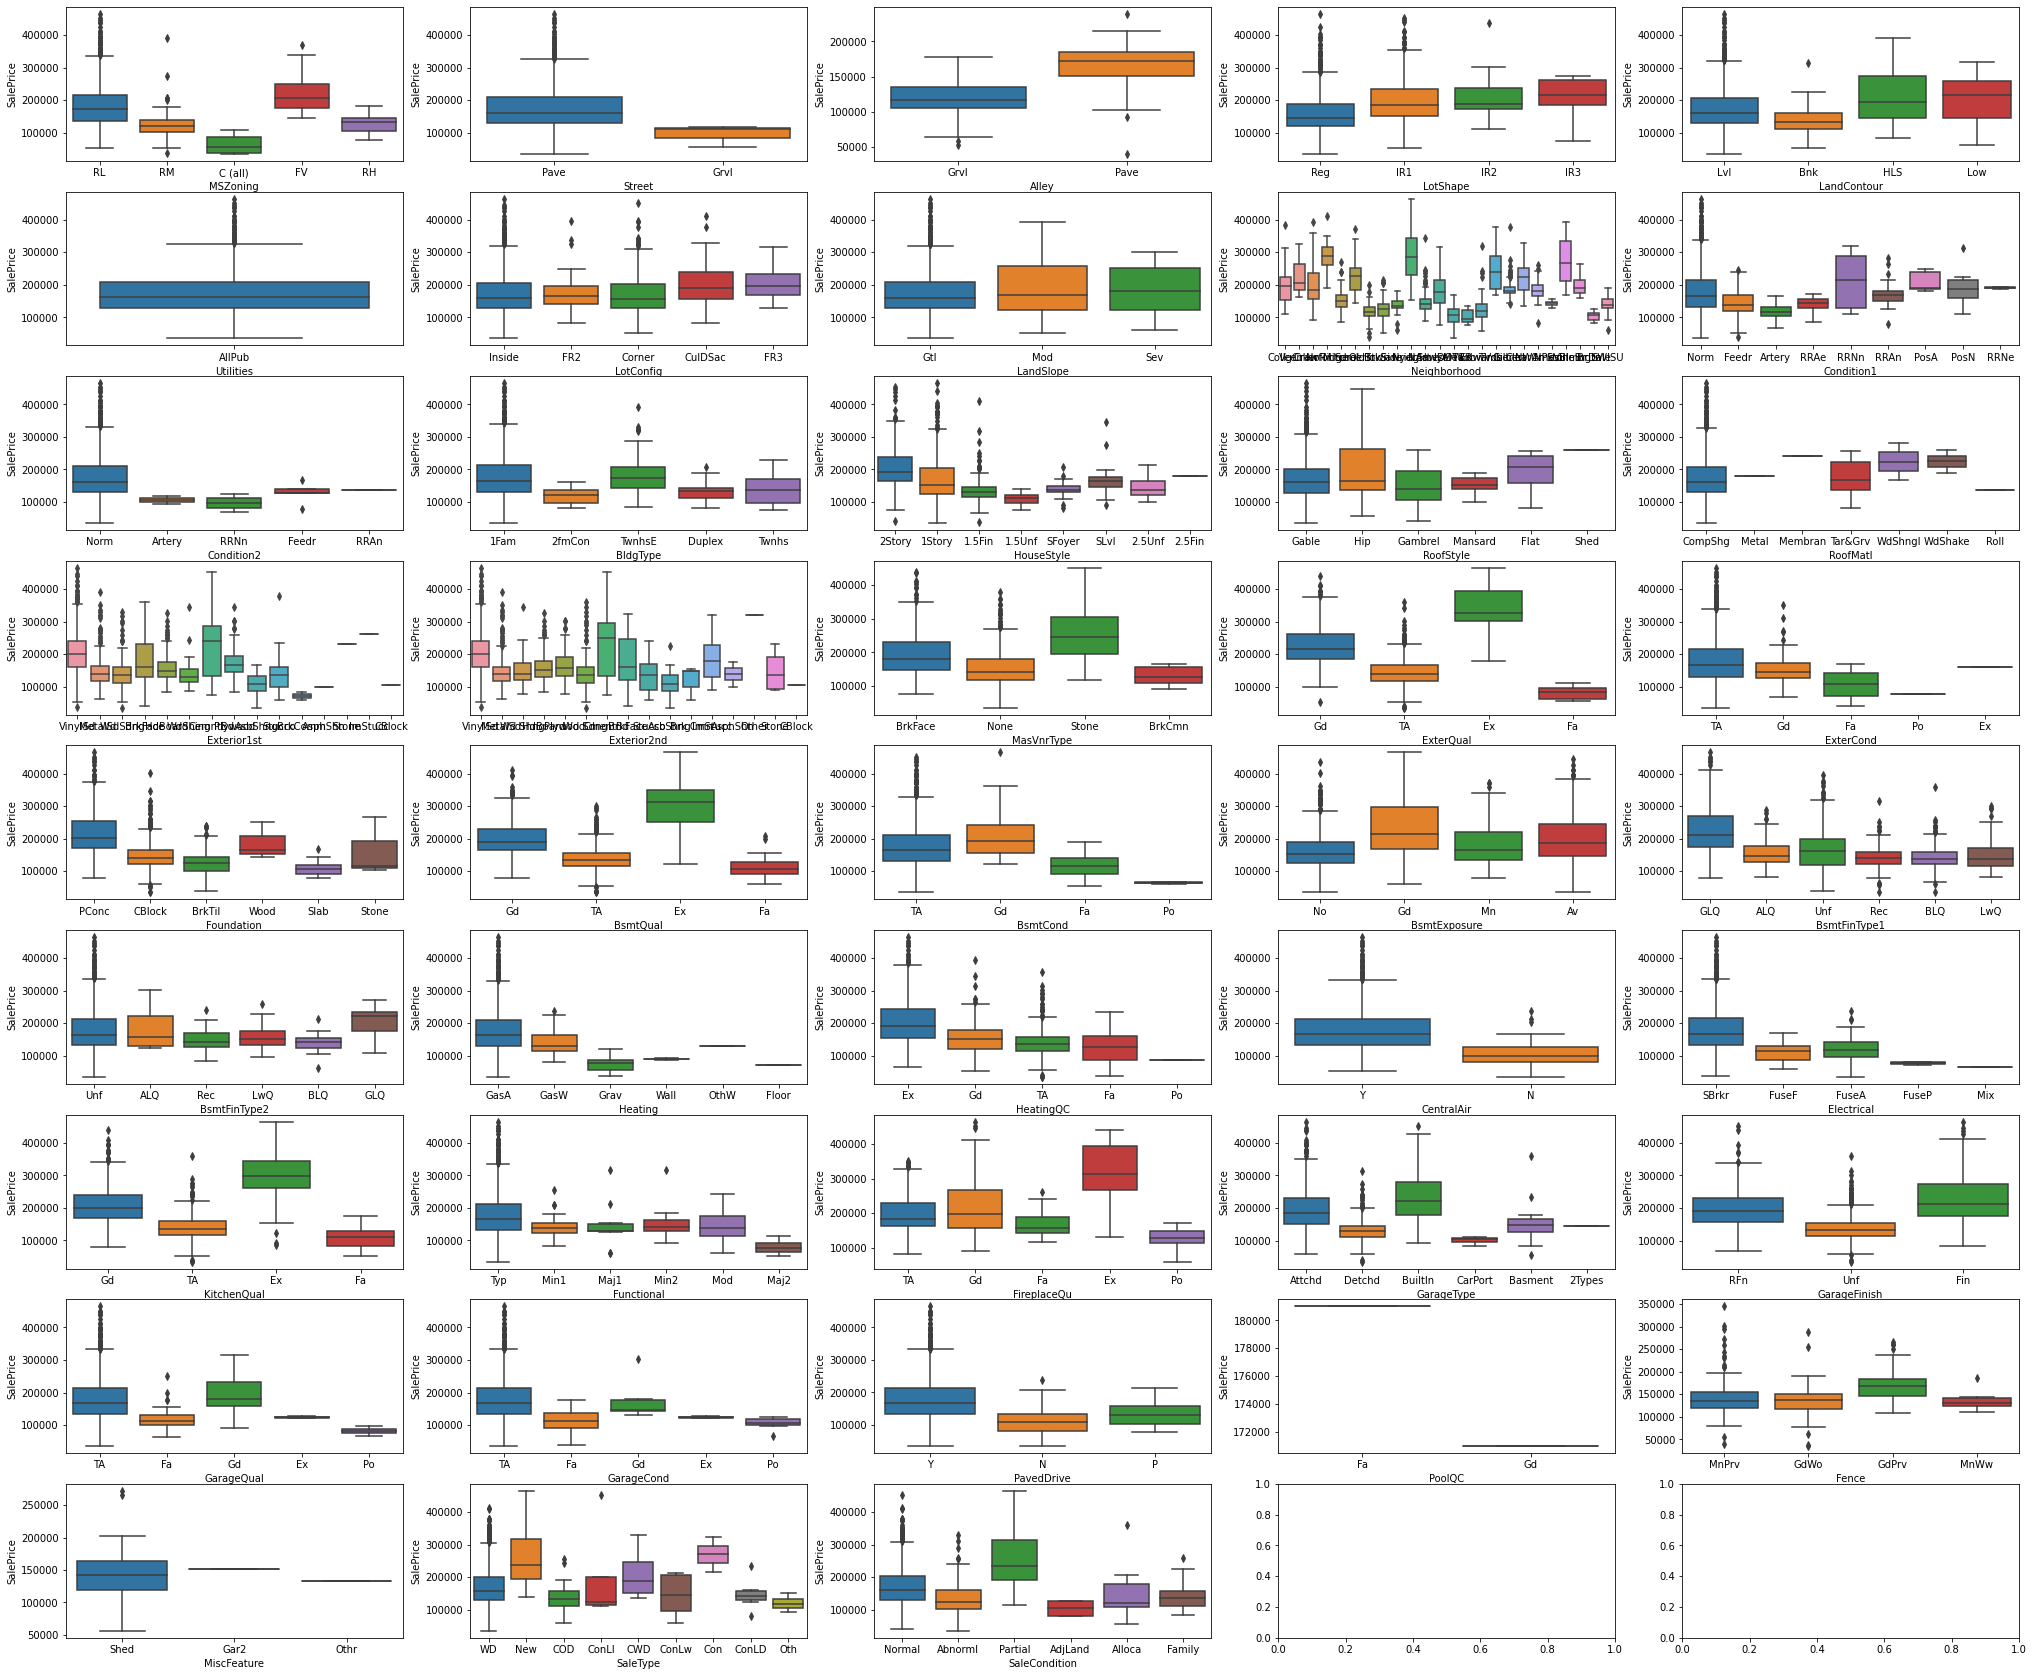

In [ ]:
fig, axs = plt.subplots(9, 5, figsize = (7*5, 6*5))

for r in range(9):
    for c in range(5):
        i = r * 5 + c
        if i < len(cat_feats):
            sns.boxplot(x = cat_feats[i], y = 'SalePrice', data = data, ax = axs[r][c])

* SalePrice와 관련이 큰 수치형/명목형 변수

In [ ]:
num_st = cols
cat_st = ['MS Zoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

## [3] Feature Engineering

### Log 변환

Skewness:  1.114752540629864
Kurtosis:  1.5097114067448119


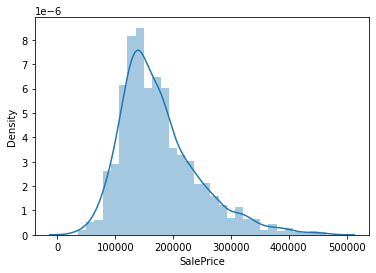

In [ ]:
sns.distplot(data['SalePrice'])
print('Skewness: ', data['SalePrice'].skew())
print('Kurtosis: ', data['SalePrice'].kurt())

Skewness:  -0.09559231557200124
Kurtosis:  0.5781980101627213


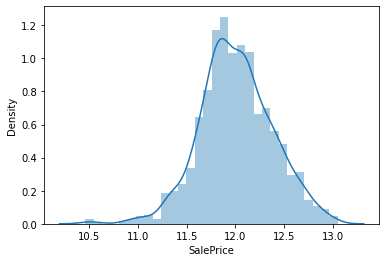

In [ ]:
sns.distplot(np.log(data['SalePrice']))
print('Skewness: ', np.log(data['SalePrice']).skew())
print('Kurtosis: ', np.log(data['SalePrice']).kurt())

### 결측 데이터 처리

* 명목형 데이터 : 있다/없다의 개념 > None 처리

In [9]:
for col in cat_feats:
    data[col].fillna('None', inplace = True)
    test[col].fillna('None', inplace = True)

* 수치형 데이터 : 0 또는 평균값으로 대체

In [10]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
            'BsmtHalfBath', 'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
    data[col].fillna(0, inplace = True)
    test[col].fillna(0, inplace = True)

In [11]:
data.fillna(data.mean(), inplace = True)
test.fillna(test.mean(), inplace = True)

### One-Hot Encoding

In [29]:
all = pd.concat([data, test])

In [30]:
allc = all.copy()
allc = pd.get_dummies(allc)

### 사칙연산

In [69]:
allc['Total_sqr_footage'] = allc['BsmtFinSF1'] + allc['BsmtFinSF2'] + allc['1stFlrSF'] + allc['2ndFlrSF']
allc['Total_Bathrooms'] = allc['FullBath'] + 0.5 * allc['HalfBath'] + allc['BsmtFullBath'] + 0.5 * allc['BsmtHalfBath']
allc['Total_porch_sf'] = allc['OpenPorchSF'] + allc['3SsnPorch'] + allc['EnclosedPorch'] + allc['ScreenPorch'] + allc['WoodDeckSF']
allc['TotalHouse'] = allc['TotalBsmtSF'] + allc['1stFlrSF'] + allc['2ndFlrSF']
allc['TotalArea'] = allc['TotalBsmtSF'] + allc['1stFlrSF'] + allc['2ndFlrSF'] + allc['GarageArea']
allc['GrLivArea_OverallQual'] = allc['GrLivArea'] * allc['OverallQual']
allc['LotArea_OverallQual'] = allc['LotArea'] * allc['OverallQual']

### 있다/없다

In [70]:
allc['haspool'] = allc['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
allc['hasgarage'] = allc['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
allc['hasbsmt'] = allc['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
allc['hasfireplace'] = allc['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## [4] Modeling & make submission

### Model: XGBoost

* DataFrame.dtypes for data must be **int**, **float** or **bool**

In [72]:
ohe_tr = allc[:len(data)]
ohe_te = allc[len(data):]

In [78]:
X = ohe_tr.drop('SalePrice', axis = 1)
y = np.log(ohe_tr['SalePrice'])
X_tr, X_vld, y_tr, y_vld = train_test_split(X, y,
                                            test_size = 0.2,
                                            random_state = 2000)

In [79]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_tr, y_tr)
print(mean_squared_error(y_vld, xgb.predict(X_vld))**0.5)

[07:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.11282513048431121


### Submission

In [81]:
sub = pd.DataFrame()
sub['ID'] = ohe_te['Id']
sub['SalePrice'] = np.exp(xgb.predict(ohe_te.drop('SalePrice', axis = 1)))

sub.to_csv('xgb.csv', index = False)